In [62]:
# -*- coding: utf-8 -*-
import openmc
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys
from PIL import Image
import numpy as np

In [63]:
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL
from src.utils.pre_processing.pre_processing import remove_previous_results, parallelepiped, plot_geometry, mesh_tally_plane
from src.utils.post_preocessing.post_processing import load_mesh_tally, gaussian_energy_broadening
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [64]:
# Définition des matériaux
materials = openmc.Materials([CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL])

In [65]:
# Surfaces
sphere = openmc.Sphere(r=1.0, surface_id=1)
detector = openmc.Sphere(x0=30., r=10.0, surface_id=2)
outer_boundary = openmc.Sphere(r=200.0, surface_id=3, boundary_type='vacuum')


/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=3.
  warn(msg, IDWarning)


In [66]:

detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = CDTE_MATERIAL
detector_cell.region = -detector

# Air cell (everything else inside the outer boundary, minus source and detector)
outer_boundary_cell = -outer_boundary
void_region = outer_boundary_cell & ~detector_cell.region
void_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=void_region)

universe = openmc.Universe(cells=[detector_cell, void_cell])
geometry = openmc.Geometry(universe)

In [67]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

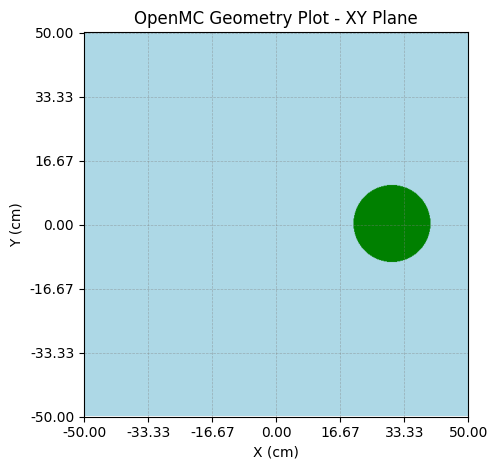

In [68]:
plot_geometry(materials=materials, width=100, height=100)

In [69]:
# Création de la source
source = openmc.Source()
source.space = openmc.stats.spherical_uniform(r_outer=15)
source.energy = openmc.stats.Discrete([661_700], [1.0])  # Énergie du photon de 662 keV pour Cs137
source.angle = openmc.stats.Monodirectional([1.0, 0.0, 0.0])
source.particle = "photon"

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [70]:
tallies = openmc.Tallies([])
mesh_tally = mesh_tally_plane(plane="xy", particule_type="photon")
tallies.append(mesh_tally)

# Tally pour le spectre d'énergie déposée dans le détecteur
energy_bins = np.linspace(1e-3, 1.0e6, 1001)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(detector_cell)

energy_dep_tally = openmc.Tally(name="pulse-height")
energy_dep_tally.filters = [cell_filter, energy_filter]
energy_dep_tally.scores = ["pulse-height"]
tallies.append(energy_dep_tally)

In [71]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 100
settings.batches = batches_number
settings.particles = 10**5
settings.source = source
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [72]:
# Export des fichiers nécessaires pour la simulation
materials.export_to_xml()
geometry.export_to_xml()
settings.export_to_xml()
tallies.export_to_xml()

In [73]:
# Exécution de la simulation
remove_previous_results(batches_number)
os.environ["OMP_NUM_THREADS"] = "1"
openmc.run()
print("Calcul fini")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [74]:
# Affichage du tally maillage (mesh tally)
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
mesh_tally = sp.get_tally(name='flux_mesh')

/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/post_preocessing/post_processing.py:44: RuntimeWarning: invalid value encountered in divide
  flux_error = flux_error / flux_data


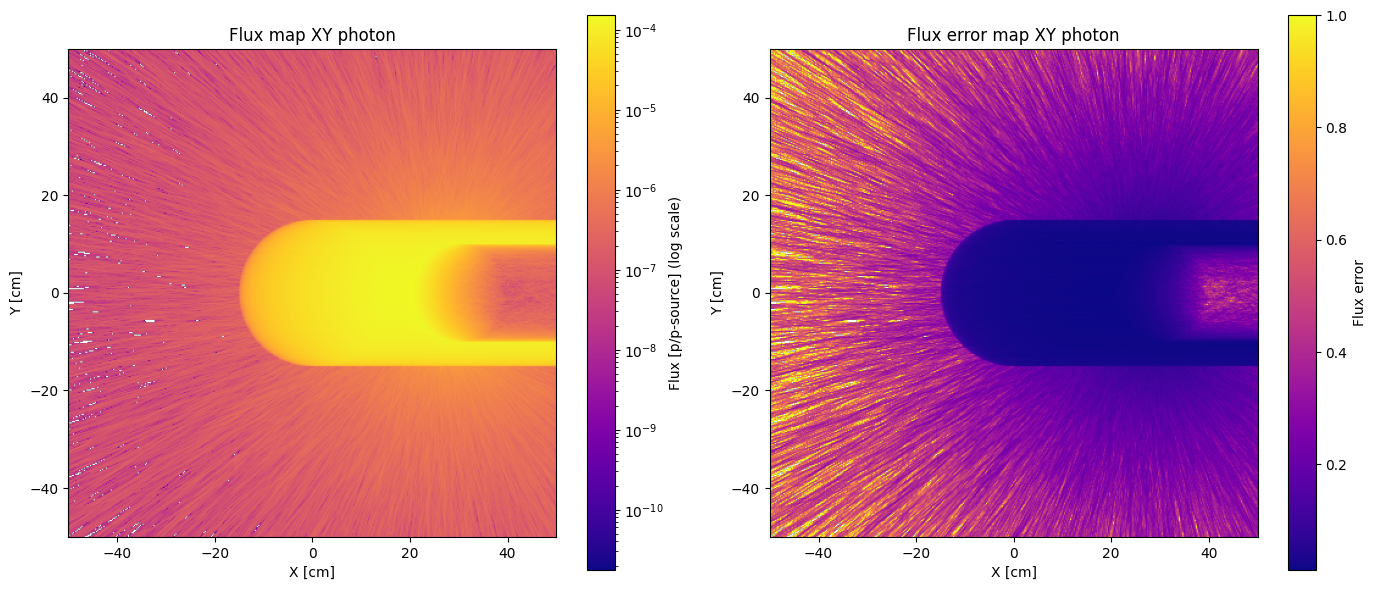

In [82]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh", particule_type="photon",
                plane = "xy", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)

/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_21715/1872544552.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


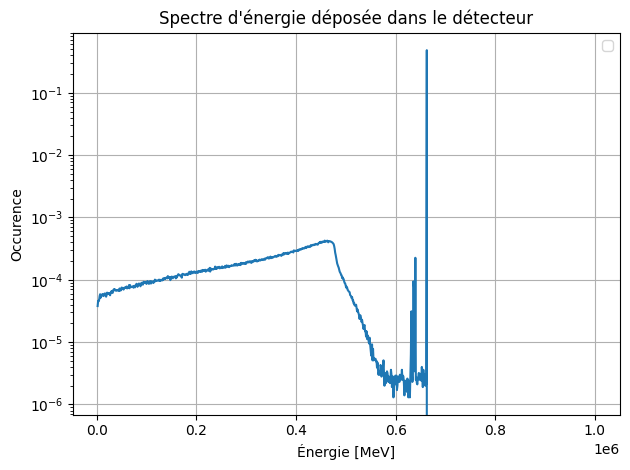

In [76]:
# Affichage du spectre d'énergie déposée
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
tally = sp.get_tally(name="pulse-height")
pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()

# Récupération des énergies moyennes par bin (approximation)
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])
spectrum = tally.mean.flatten()
spectrum_std = tally.std_dev.flatten()

# Tracé
plt.figure()
plt.semilogy(energy_bin_centers, spectrum)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Spectre d'énergie déposée dans le détecteur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_21715/2893380041.py:15: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(energy_bin_centers, spectrum_std/spectrum)
/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_21715/2893380041.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


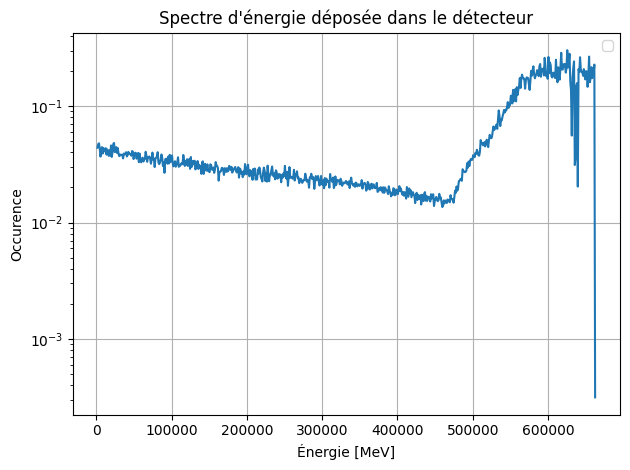

In [ ]:
# get the statistical error associated to the spectrum
# Affichage du spectre d'énergie déposée
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
tally = sp.get_tally(name="pulse-height")
pulse_height_error = tally.get_values(scores=['pulse-height']).flatten()

# Récupération des énergies moyennes par bin (approximation)
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])
spectrum = tally.mean.flatten()
spectrum_std = tally.std_dev.flatten()


# Tracé
plt.figure()
plt.semilogy(energy_bin_centers, spectrum_std/spectrum)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Erreur du spectre d'énergie")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
a, b, c = 1, 1, 0.0002
number_broadening_samples = 1e6

samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=pulse_height_values[1:]/np.sum(pulse_height_values[1:]))
broaded_pulse_height_values = gaussian_energy_broadening(E=samples, a=a, b=b, c=c)

broaded_spectrum, _ = np.histogram(broaded_pulse_height_values, bins=energy_bins)
renormalized_broaded_spectrum = broaded_spectrum / np.sum(broaded_spectrum) * np.sum(pulse_height_values[1:])

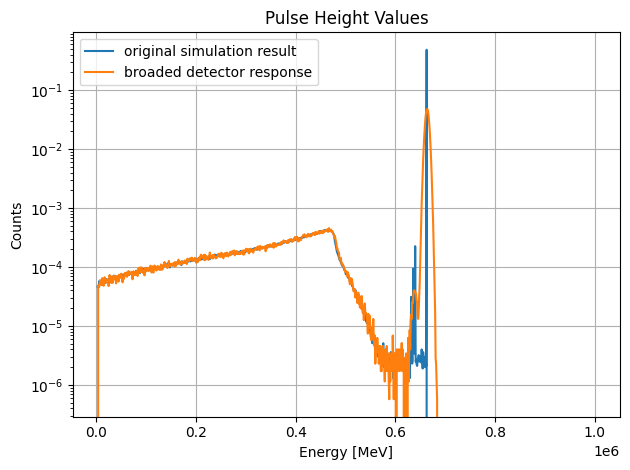

In [78]:
plt.figure()
plt.semilogy(energy_bin_centers[1:], pulse_height_values[1:], label="original simulation result")
plt.semilogy(energy_bin_centers[1:], renormalized_broaded_spectrum[1:], label="broaded detector response")
plt.legend()
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()

In [79]:
# get the FWHM of the broaded spectrum at 662 keV
def closest_value_index(array, value):
    """Return the index of the closest value in the array to the given value."""
    return (np.abs(array - value)).argmin()
peak_index = closest_value_index(energy_bin_centers, 661700)
half_max = renormalized_broaded_spectrum[peak_index] / 2
left_index = np.where(renormalized_broaded_spectrum[:peak_index] < half_max)[0][-1]
right_index = np.where(renormalized_broaded_spectrum[peak_index:] < half_max)[0][0] + peak_index
fwhm = energy_bin_centers[right_index] - energy_bin_centers[left_index]
print(f"FWHM at 662 keV: {fwhm/1000:.2f} keV on spectrum")


FWHM_geb = a + b * np.sqrt((662_000) + c * 662_000**2)
print(f"FWHM at 662 keV: {FWHM_geb/1000:.2f} keV on GEB formula")

FWHM at 662 keV: 12.00 keV on spectrum
FWHM at 662 keV: 9.40 keV on GEB formula
